In [4]:
import joblib
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE

In [5]:
#Load liked track ids and all liked songs features from csv
liked_track_ids = joblib.load('../Joblib_Objects/liked_track_ids')

liked_songs_df = pd.read_csv('../CSV_Data/liked_songs.csv',index_col=0)

#Load random songs csv
random_songs_df = pd.read_csv('../CSV_Data/random_songs_formatted.csv',index_col=0)

In [6]:
#Remove songs from random_songs_df if they already exist as a liked song
random_songs_df = random_songs_df.loc[~random_songs_df['track_id'].isin(liked_track_ids)]

In [7]:
#Format dataframe for model creation

#If song is a liked song, this will define a favourite song (1 for favourite, 0 for non-favourite)
liked_songs_df['favourite'] = 1
random_songs_df['favourite'] = 0

#Format genres to only have 1 listed
liked_songs_df['genre'] = liked_songs_df['genre'].map(lambda x: x.split('[')[1].split(']')[0].split(', ')[0].strip("'"))
liked_songs_df['genre'] = liked_songs_df['genre'].map(lambda x: 'Not Available' if x == '' else x)

In [8]:
#Drop track id and artist
liked_songs_df = liked_songs_df.drop(columns=['track_id','artist'])
random_songs_df = random_songs_df.drop(columns=['track_id'])

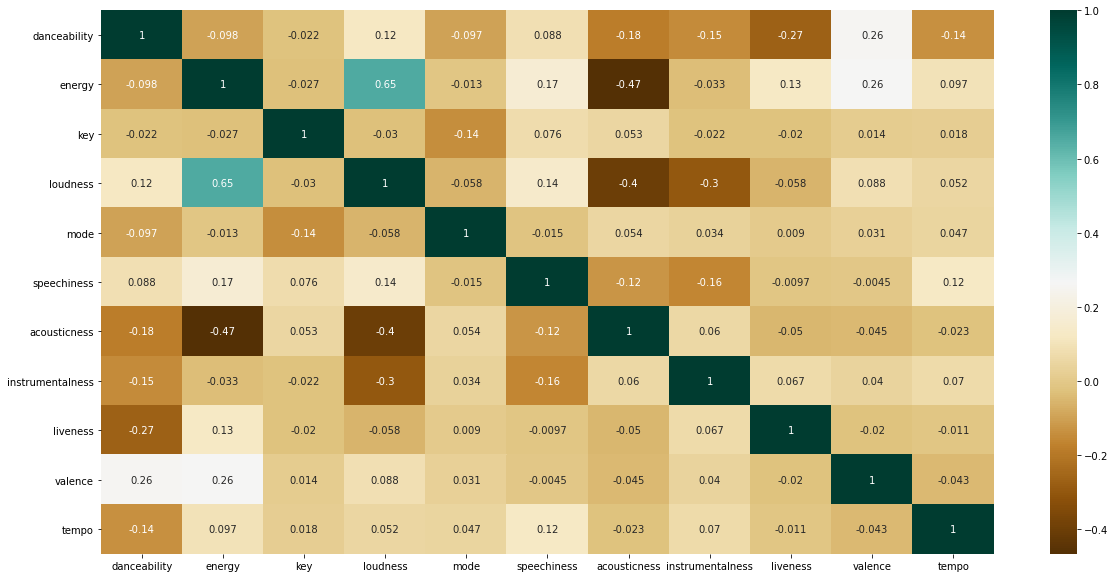

In [9]:
#Show Correlation Matrix of combined dataframe
liked_songs_df_matrix = liked_songs_df.drop(columns='favourite')

plt.figure(figsize=(20,10))
c_liked = liked_songs_df_matrix.corr()
corr_liked = sns.heatmap(c_liked,cmap="BrBG",annot=True)

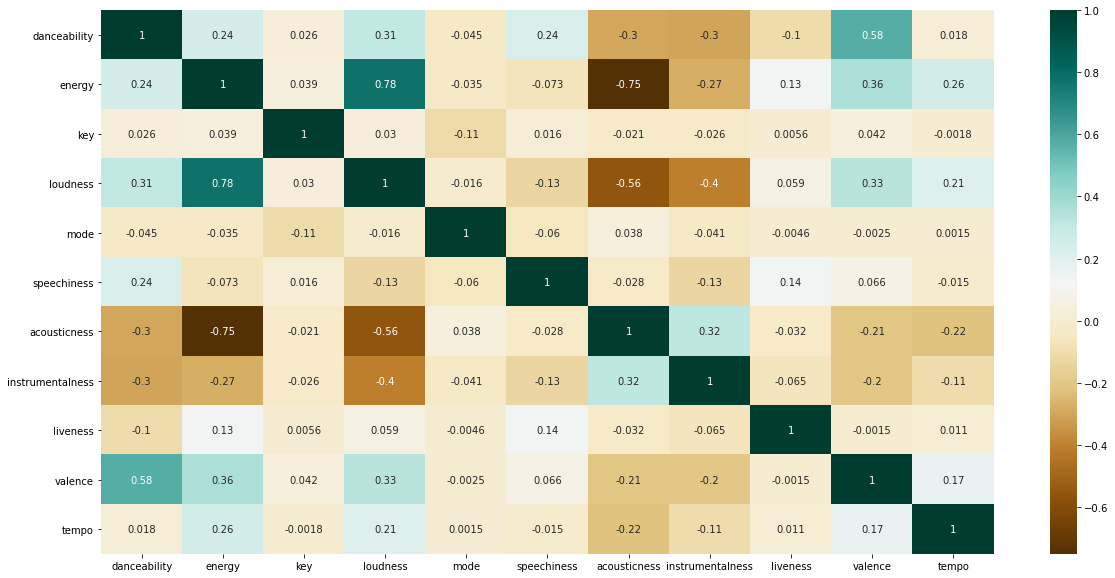

In [10]:
#Show Correlation Matrix of combined dataframe
random_songs_df_matrix = random_songs_df.drop(columns='favourite')

plt.figure(figsize=(20,10))
c_random = random_songs_df_matrix.corr()
corr_random = sns.heatmap(c_random,cmap="BrBG",annot=True)

In [11]:
#Combine liked songs and random songs data into one dataframe
combined_songs_df = pd.concat([liked_songs_df,random_songs_df])
combined_songs_df = combined_songs_df.reset_index(drop=True)

In [12]:
#Label encode genres
from sklearn.preprocessing import LabelEncoder

genres_label_encoder = LabelEncoder()
genres = combined_songs_df['genre'].to_list()
genres_label_encoder.fit(genres)

combined_songs_df['genre'] = combined_songs_df['genre'].map(lambda x: genres_label_encoder.transform([x])[0])

#Dump LabelEncoder using joblib to be used when using model to determine if song is favourite
joblib.dump(genres_label_encoder,'../Joblib_Objects/genres_label_encoder')

['../Joblib_Objects/genres_label_encoder']

In [13]:
#Separate combined dataframe into X (features) and y (category)
y = combined_songs_df['favourite']
X = combined_songs_df.drop(columns='favourite')

#Scale values to remove bias in values
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

#Dump scaler using joblib
joblib.dump(scaler,'../Joblib_Objects/scaler')

['../Joblib_Objects/scaler']

In [14]:
#Check ratio of favourites to non-favourites
combined_songs_df['favourite'].value_counts()

0    17503
1      983
Name: favourite, dtype: int64

In [16]:
#Resample and balance with SMOTE
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [24]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import f1_score
from scipy.stats import uniform, randint

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
import xgboost

In [18]:
# Train / Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .20)

In [19]:
# Logistic Regression
lr = LogisticRegression()
lr_scores = cross_val_score(lr, X_train, y_train, cv=10, scoring="f1")
np.mean(lr_scores)

0.7700555661729134

In [27]:
# Hyperparameter optimization for Decision Tree Classifier
test_dt = DecisionTreeClassifier()
search_params_dt = {'max_leaf_nodes': list(range(2, 100)), 
                    'min_samples_split': [2, 3, 4],
                    "max_depth": randint(10, 30),
                    "criterion": ['gini','entropy'],
                    "max_features": randint(1, 9),
                    "min_samples_leaf": randint(1, 9),
                   }
                                           
search_dt = RandomizedSearchCV(test_dt, param_distributions=search_params_dt, random_state=42, n_iter=400, cv=8, 
                            verbose=1, n_jobs=8, return_train_score=True)

search_dt.fit(X_train, y_train)

top_rank_dt = np.flatnonzero(search_dt.cv_results_['rank_test_score'] == 1)[0]
optimized_params_dt = search_dt.cv_results_['params'][top_rank]

Fitting 8 folds for each of 400 candidates, totalling 3200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   19.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   26.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   38.5s


KeyboardInterrupt: 

In [21]:
# Decision Tree
dt = DecisionTreeClassifier(**optimized_params_dt)
dt_scores = cross_val_score(dt, X_train, y_train, cv=10, scoring="f1")
np.mean(dt_scores)

0.9175110679772018

In [28]:
# Hyperparameter optimization of RandomForestClassifier
test_rf = RandomForestClassifier()
search_params_rf = {'bootstrap': [True, False],
                     'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                     'max_features': ['auto', 'sqrt'],
                     'min_samples_leaf': [1, 2, 4],
                     'min_samples_split': [2, 5, 10],
                     'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
                   }
                                           
search_rf = RandomizedSearchCV(test_dt, param_distributions=search_params_rf, random_state=42, n_iter=400, cv=8, 
                            verbose=1, n_jobs=8, return_train_score=True)

search_rf.fit(X_train, y_train)

top_rank_rf = np.flatnonzero(search_rf.cv_results_['rank_test_score'] == 1)[0]
optimized_params_rf = search_rf.cv_results_['params'][top_rank]

Fitting 8 folds for each of 400 candidates, totalling 3200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [23]:
# Cross-validation for RandomForestClassifier
rf = RandomForestClassifier(**optimized_params_rf)
rf_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring="f1")
np.mean(rf_scores)

0.960025106161555

In [ ]:
# Hyperparameter optimization of XGBClassifier
test_xgb = xgb.XGBClassifier(tree_method='gpu_hist')

search_params_xgb = { "colsample_bytree": uniform(0.7, 0.3),
            "gamma": uniform(0, 1),
            "learning_rate": uniform(0.03, 0.3), # default 0.1 
            "max_depth": randint(2, 6), # default 3
            "n_estimators": randint(100, 150), # default 100
            "subsample": uniform(0.9, 0.4),
            "reg_lambda": uniform(0.1, 20),
            "scale_pos_weight": randint(1, 5)
        }
search_xgb = RandomizedSearchCV(test_xgb, param_distributions=search_params_xgb, random_state=42, n_iter=400, cv=8, verbose=1, n_jobs=8, return_train_score=True)

search_xgb.fit(X_train, y_train)

top_rank_xgb = np.flatnonzero(search_xgb.cv_results_['rank_test_score'] == 1)[0]
optimized_params_xgb = search_xgb.cv_results_['params'][top_rank]

In [ ]:
# Cross-validation for XGBClassifier
xgb = xgb.XGBClassifier(tree_method='gpu_hist',**optimized_params_xgb)
xgb_scores = cross_val_score(xgb, X_train, y_train, cv=10, scoring="f1")
np.mean(xgb_scores)